In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import os
import importlib

# stdlib imports
from datetime import datetime, timedelta

# Third party imports
import matplotlib.pyplot as plt

# Local imports
from libcomcat.search import count, get_event_by_id, search
from libcomcat.dataframes import get_detail_data_frame

In [118]:
sliq = pd.read_csv('sliq.csv')

In [119]:
sliq

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1,depth,dmass,cp
0,162,-50.3221,-72.2500,2021-10-13 07:55:29.195,5.4,POINT (-72.25 -50.3221),5.4,0.0,6.907373e-11,0.250172,0.749828,1.0,10.00,11.095148,1.821275
1,191,38.8893,135.4527,2021-09-29 08:37:05.619,6.1,POINT (135.4527 38.8893),5.4,0.0,6.907373e-11,0.880555,0.119445,1.0,364.00,-12.225787,1.936980
2,211,29.1944,105.3650,2021-09-15 20:33:31.851,5.4,POINT (105.365 29.1944),5.4,0.0,6.907373e-11,0.890814,0.109186,1.0,7.12,24.034846,3.285261
3,1404,40.9035,28.1502,2019-09-26 10:59:25.648,5.7,POINT (28.1502 40.9035),5.4,0.0,6.907373e-11,0.840714,0.159286,1.0,8.00,-11.874613,1.936980
4,1410,33.0779,73.7936,2019-09-24 11:01:54.990,5.4,POINT (73.7936 33.0779),5.4,0.0,6.907373e-11,0.869885,0.130115,1.0,10.00,-16.050167,2.832101
5,1414,41.3375,19.5303,2019-09-21 14:04:25.803,5.6,POINT (19.5303 41.3375),5.4,0.0,6.907373e-11,0.854188,0.145812,1.0,20.00,-31.479464,3.372833
6,1512,-18.2242,120.3584,2019-07-14 05:39:23.420,6.6,POINT (120.3584 -18.2242),5.4,0.0,6.907373e-11,0.388103,0.611897,1.0,10.00,15.505109,2.233716
7,1716,-3.2806,90.2747,2019-03-10 07:53:20.170,5.5,POINT (90.2747 -3.2806),5.4,0.0,6.907373e-11,0.592813,0.407187,1.0,10.00,-8.509723,1.897861
8,1833,-20.6428,32.8029,2018-12-22 05:37:38.870,5.6,POINT (32.8029 -20.6428),5.4,0.0,6.907373e-11,0.878817,0.121183,1.0,16.00,-11.109004,2.354140
9,1876,27.1986,96.9185,2018-11-28 10:17:06.970,5.4,POINT (96.91849999999999 27.1986),5.4,0.0,6.907373e-11,0.880594,0.119406,1.0,11.00,-11.787423,1.936980


In [133]:
# datetime(np.array(sliq.time)[0])
# sliq.iloc[20].time
times=sliq.time
times.to_frame()
times[1]

'2021-09-29 08:37:05.619'

In [356]:
rakes1 = []
rakes2 = []
dips1 = []
dips2 = []

for i in range(49):
    utc_t=datetime.strptime(times[i],'%Y-%m-%d %H:%M:%S.%f')
    sliq_times.append(utc_t)
    this_earthquake =search(starttime=sliq_times[i]-timedelta(seconds=1), endtime=sliq_times[i]+timedelta(seconds=1))
    
    # Rake from nodal plane 1
    if len(this_earthquake) > 0:
        detail=get_detail_data_frame(this_earthquake)
        if 'us_Mww_np1_rake' in detail.keys():
            rake1 = np.array(detail.us_Mww_np1_rake)[-1]
#             print (rake1)
        else:
            rake1 = np.nan
#             print('No MT')
    else:
        rake1 = np.nan
#         print('No EQ')

    # Dip from nodal plane 1
    if len(this_earthquake) > 0:
        detail=get_detail_data_frame(this_earthquake)
        if 'us_Mww_np1_dip' in detail.keys():
            dip1 = np.array(detail.us_Mww_np1_dip)[-1]
#             print (dip1)
        else:
            dip1 = np.nan
#             print('No dip')
    else:
        dip1 = np.nan
#         print('No EQ')

    # Rake from nodal plane 2
    if len(this_earthquake) > 0:
        detail=get_detail_data_frame(this_earthquake)
        if 'us_Mww_np2_rake' in detail.keys():
            rake2 = np.array(detail.us_Mww_np2_rake)[-1]
#             print (rake2)
        else:
            rake2 = np.nan
#             print('No MT')
    else:
        rake2 = np.nan
#         print('No EQ')

    # Dip from nodal plane 2
    if len(this_earthquake) > 0:
        detail=get_detail_data_frame(this_earthquake)
        if 'us_Mww_np2_dip' in detail.keys():
            dip2 = np.array(detail.us_Mww_np2_dip)[-1]
#             print (dip2)
        else:
            dip2 = np.nan
#             print('No dip')
    else:
        dip2 = np.nan
#         print('No EQ')

        
    rakes1.append(rake1)
    dips1.append(dip1)
    rakes2.append(rake2)
    dips2.append(dip2)

In [364]:
sliq['us_Mww_np1_rake'] = rakes1
sliq['us_Mww_np2_rake'] = rakes2
sliq['us_Mww_np1_dip'] = dips1
sliq['us_Mww_np2_dip'] = dips2

In [365]:
sliq

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1,depth,dmass,cp,us_Mww_np1_rake,us_Mww_np2_rake,us_Mww_np1_dip,us_Mww_np2_dip
0,162,-50.3221,-72.2500,2021-10-13 07:55:29.195,5.4,POINT (-72.25 -50.3221),5.4,0.0,6.907373e-11,0.250172,0.749828,1.0,10.00,11.095148,1.821275,NaN,NaN,NaN,NaN
1,191,38.8893,135.4527,2021-09-29 08:37:05.619,6.1,POINT (135.4527 38.8893),5.4,0.0,6.907373e-11,0.880555,0.119445,1.0,364.00,-12.225787,1.936980,-51.02,-97.81,12.30,80.47
2,211,29.1944,105.3650,2021-09-15 20:33:31.851,5.4,POINT (105.365 29.1944),5.4,0.0,6.907373e-11,0.890814,0.109186,1.0,7.12,24.034846,3.285261,66.95,103.52,31.56,61.20
3,1404,40.9035,28.1502,2019-09-26 10:59:25.648,5.7,POINT (28.1502 40.9035),5.4,0.0,6.907373e-11,0.840714,0.159286,1.0,8.00,-11.874613,1.936980,42.00,123.34,41.51,63.67
4,1410,33.0779,73.7936,2019-09-24 11:01:54.990,5.4,POINT (73.7936 33.0779),5.4,0.0,6.907373e-11,0.869885,0.130115,1.0,10.00,-16.050167,2.832101,163.92,78.16,12.31,86.61
5,1414,41.3375,19.5303,2019-09-21 14:04:25.803,5.6,POINT (19.5303 41.3375),5.4,0.0,6.907373e-11,0.854188,0.145812,1.0,20.00,-31.479464,3.372833,92.70,88.34,31.59,58.45
6,1512,-18.2242,120.3584,2019-07-14 05:39:23.420,6.6,POINT (120.3584 -18.2242),5.4,0.0,6.907373e-11,0.388103,0.611897,1.0,10.00,15.505109,2.233716,173.39,11.84,78.24,83.52
7,1716,-3.2806,90.2747,2019-03-10 07:53:20.170,5.5,POINT (90.2747 -3.2806),5.4,0.0,6.907373e-11,0.592813,0.407187,1.0,10.00,-8.509723,1.897861,-172.08,-14.27,75.86,82.32
8,1833,-20.6428,32.8029,2018-12-22 05:37:38.870,5.6,POINT (32.8029 -20.6428),5.4,0.0,6.907373e-11,0.878817,0.121183,1.0,16.00,-11.109004,2.354140,-98.90,-82.95,38.65,51.90
9,1876,27.1986,96.9185,2018-11-28 10:17:06.970,5.4,POINT (96.91849999999999 27.1986),5.4,0.0,6.907373e-11,0.880594,0.119406,1.0,11.00,-11.787423,1.936980,62.57,114.56,44.77,51.31


## Rake vales:
#### - 90° for a pure reverse fault
#### - -90° for a pure normal fault
#### - 0° for a left-lateral strike-slip fault
#### - 180° (or -180°) for a right-lateral strike-slip fault


Text(0.5, 1.0, 'Correlation between surface load and rake')

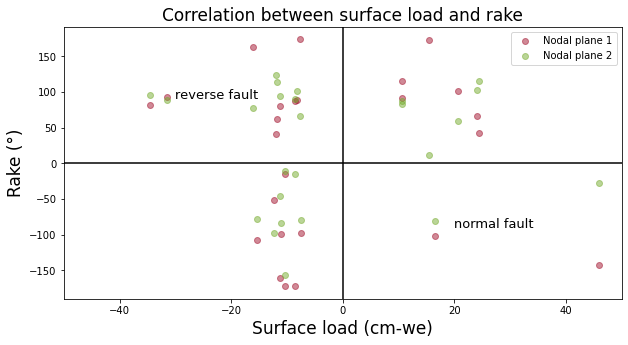

In [416]:
# scatter plot (y=load,x=rake)

fig,ax = plt.subplots(figsize=(10,5))

plot1 = ax.scatter(sliq.dmass, sliq.us_Mww_np1_rake, alpha=0.5, c='#A2142F',label='Nodal plane 1')
plot2 = ax.scatter(sliq.dmass, sliq.us_Mww_np2_rake, alpha=0.5, c='#77AC30',label='Nodal plane 2')
ax.legend(handles=[plot1, plot2])
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k') 
ax.set_xlim([-50,50])
ax.text(-30, 90, 'reverse fault', fontsize=13)
ax.text(20, -90, 'normal fault', fontsize=13)
ax.set_xlabel('Surface load (cm-we)', fontsize = 17)
ax.set_ylabel("Rake (\N{DEGREE SIGN})", fontsize = 17)
ax.set_title("Correlation between surface load and rake", fontsize = 17)